### Question 2

The file ‘FTSE_sample.mat’ contains minute market order (MO) as well as bestbid and best ask prices at the end of every minute of a FTSE constituent duringthe 2008 financial crisis.
- Calculate minutely returns of the stock based on mid-price and reportsummary statistics.
- Plot autocorrelation function of minutely order flows up to 20 lags. Analyse your result. Order flow is defined as net MO within each minute.
- Regress minutely return on return of previous minute and the contemporaneous order flow. Interpret your regression results and their implications.
- Develop a trading strategy based on cumulative order flows of previous 30minutes. Estimate the cumulative return of your trading strategy.
- Compare the return of your strategy and the return of the stock during thewhole period. Why do you make (lose) money by implementing this trading strategy?

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf

In [51]:
data = sio.loadmat('data/FTSE_sample.mat')
Bestask = [e[0] for e in data['Bestask']]
Bestbid = [e[0] for e in data['Bestbid']]
MO = [e[0] for e in data['MO']]

DATA = pd.DataFrame({'MO': MO, 'Bestask': Bestask, 'Bestbid': Bestbid})
DATA['Midprice'] = (DATA['Bestask'] + DATA['Bestbid']) / 2
DATA['Spread'] = DATA['Bestask'] - DATA['Bestbid']
DATA['returns'] = np.log(DATA['Midprice']).diff()
DATA['LaggedReturns'] = DATA['returns'].shift(1)
DATA

,MO,Bestask,Bestbid,Midprice,Spread,returns,LaggedReturns
0,0.0000,149.35,149.10,149.225,0.25,NaN,NaN
1,4.1283,149.35,149.00,149.175,0.35,-0.000335,NaN
2,-2.8656,149.50,149.25,149.375,0.25,0.001340,-0.000335
3,5.4553,149.95,149.85,149.900,0.10,0.003508,0.001340
4,122.4072,149.90,149.60,149.750,0.30,-0.001001,0.003508
...,...,...,...,...,...,...,...
62215,-43.7396,125.85,125.75,125.800,0.10,-0.001787,-0.000198
62216,2.1216,125.95,125.85,125.900,0.10,0.000795,-0.001787
62217,20.9690,126.00,125.90,125.950,0.10,0.000397,0.000795
62218,27.2930,125.95,125.90,125.925,0.05,-0.000199,0.000397


In [60]:
DATA['returns'].describe()

count    62219.000000
mean        -0.000003
std          0.001828
min         -0.077190
25%         -0.000588
50%          0.000000
75%          0.000580
max          0.055761
Name: returns, dtype: float64

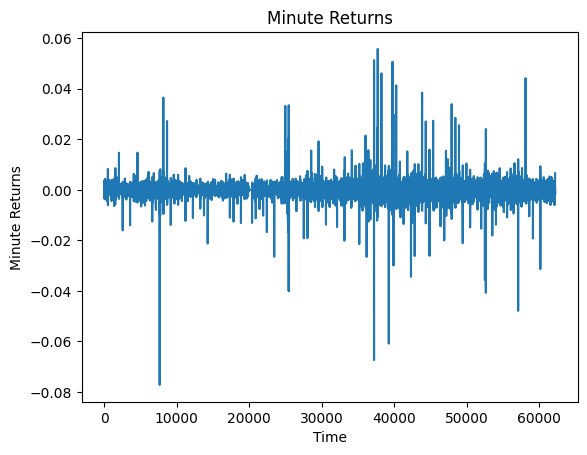

In [55]:
DATA['returns'].plot()
plt.xlabel('Time')
plt.ylabel('Minute Returns')
plt.title('Minute Returns')
plt.show()

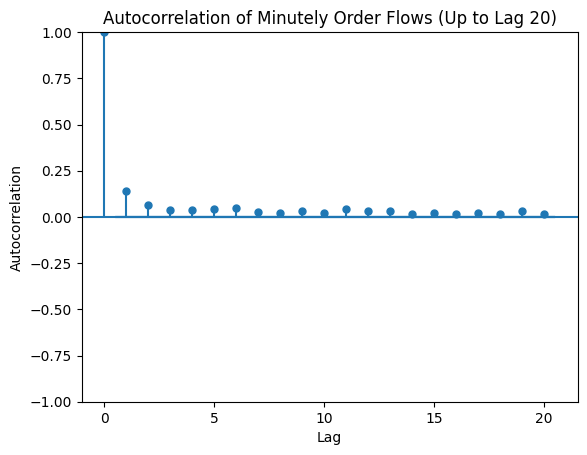

In [52]:
order_flow = DATA['MO']
lags = 20

plot_acf(order_flow, lags=lags)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Minutely Order Flows (Up to Lag 20)')
plt.show()


In [53]:
MODEL  = smf.ols(formula='returns ~ LaggedReturns + MO', data=DATA).fit()
MODEL.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                returns   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     4361.
Date:                Sun, 10 Mar 2024   Prob (F-statistic):               0.00
Time:                        17:11:04   Log-Likelihood:             3.0804e+05
No. Observations:               62218   AIC:                        -6.161e+05
Df Residuals:                   62215   BIC:                        -6.161e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.003e-06   6.86e-06      0.146      0.884   -1.25e-05    1.45e-05
LaggedReturns    -0.0379      0.004    -10.088      0.000      -0.045      -0.031
MO             2.429e-05   2.61e-07     93.129      0.000    2.38e-05    2.48e-05
==============================================================================
Omnibus:                    44198.801   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        144438701.075
Skew:                          -1.791   Prob(JB):                         0.00
Kurtosis:                     239.015   Cond. No.                     1.44e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/var/folders/nd/79363p2x1v97bfz0bshy96wh0000gn/T/ipykernel_59157/3701448805.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  DATA['positions_long'] = DATA['long_entry'].shift(1).fillna(False)
/var/folders/nd/79363p2x1v97bfz0bshy96wh0000gn/T/ipykernel_59157/3701448805.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  DATA['positions_exit'] = DATA['long_exit'].shift(1).fillna(False)
/var/folders/nd/79363p2x1v97bfz0bshy96wh0000gn/T/ipykernel_59157/3701448805.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through 

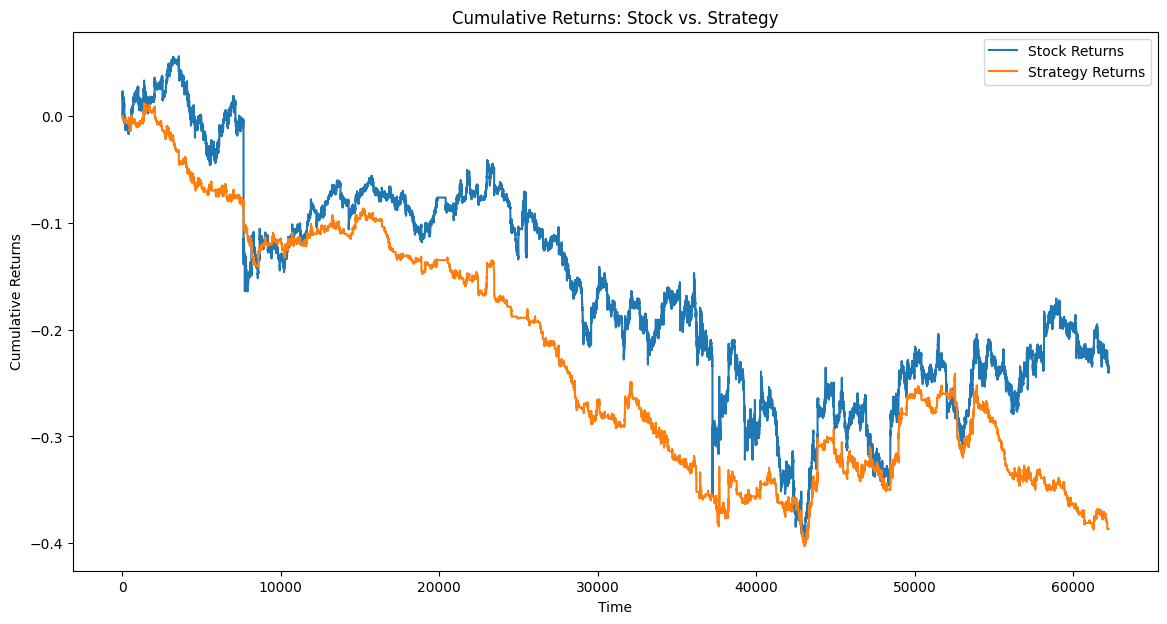

In [54]:
DATA['CumulativeOrderFlow'] = DATA['MO'].rolling(window=30).sum()

# Calculate mid-price momentum over a 30-minute rolling window
# This example uses a simple percentage change. Adjust according to your strategy's definition of momentum.
DATA['MidPriceMomentum'] = DATA['Midprice'].pct_change(periods=29)

DATA['long_entry'] = (DATA['CumulativeOrderFlow'] > 0) & (DATA['MidPriceMomentum'] > 0)
DATA['long_exit'] = ((DATA['CumulativeOrderFlow'] < 0) | (DATA['MidPriceMomentum'] < 0))

DATA['positions_long'] = DATA['long_entry'].shift(1).fillna(False)
DATA['positions_exit'] = DATA['long_exit'].shift(1).fillna(False)

# Calculate strategy returns: enter at mid_price and exit at the next mid_price after a long_exit signal
DATA['strategy_returns'] = np.where(DATA['positions_long'], DATA['Midprice'].pct_change(), 0)
DATA['strategy_returns'].where(~DATA['positions_exit'], 0, inplace=True)

# Calculate cumulative returns for the stock and the strategy
DATA['cumulative_stock_returns'] = (1 + DATA['returns']).cumprod() - 1
DATA['cumulative_strategy_returns'] = (1 + DATA['strategy_returns']).cumprod() - 1


plt.figure(figsize=(14, 7))
plt.plot(DATA.index, DATA['cumulative_stock_returns'], label='Stock Returns')
plt.plot(DATA.index, DATA['cumulative_strategy_returns'], label='Strategy Returns')
plt.title('Cumulative Returns: Stock vs. Strategy')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()